# Tutorial 11-02 - Exploring Python Charting Packages

In our first exercise, we used the built-in plotting that *pandas* and *matplotlib* have to offer.  We outputted some maps that met our colleagues' needs functionally, but left some room for aesthetic improvements.  In this tutorial, we'll explore some of the other charting packages commonly used in Python and see how they work compared with *matplotlib*.  

This will be a slightly different tutorial than most.  After our first step of gathering data, we'll spend some time creating charts with the *seaborn*, *plotly*, and *arcpy* packages respectively.

## Data Preparation

In this first step, we'll repeat some of the logic we used in the previous tutorial.  We're going to log into ArcGIS Online, find a census housing data layer with statistics at the county level, then query that layer for a single state.

#### 1.  Log into ArcGIS Online

Start by logging into ArcGIS Online.  You'll do this by importing the `arcgis` package and creating a `GIS` object that represents your credentials.

In [1]:
# import the arcgis package
import arcgis

# set up ArcGIS Online credentials
gis = arcgis.GIS("home")


#### 2.  Identify a data layer.

Find the Census Housing Statistics data layer used in the previous Tutorial.

In [2]:
item_2020_census_housing = gis.content.get('81d9e89b8b574a649ff6e14f61c8494f')
lyr_counties = item_2020_census_housing.layers[2]

#### 3.  Query the data for a state.

Query the layer for a single state.  Similarly to the previous tutorial, you can use California to get a reasonably sized dataset.

In [18]:
df_single_state = lyr_counties.query(
    where = "STATE = 'California'",
    as_df = True,
    return_geometry = True
)

NOTE - When you're doing something like charting that doesn't necessarily require a geospatial compontent to the data, you can disregard the data's geometry.  This can reduce the amount of data you have to deal with in memory drastically (as large polygons can take up a lot of space).

#### 4.  Rename columns to field aliases

In this step, you'll use the aliases from the hosted feature layer to rename the columns in your DataFrame.  This will make the columns you're displaying more user-friendly and readable

In [19]:
field_aliases = {f['name']: f['alias'] 
              for f in lyr_counties.properties.fields}


df_single_state = df_single_state.rename(columns=field_aliases)

#### 5.  Sort the data.

Sort the data by "Total Housing Units" descending using the DataFrame's `.sort_values()` method.

In [20]:
df_single_state = df_single_state.sort_values(
    'Total Housing Units',
    ascending=False
)

## Seaborn

#### 1.  Import Seaborn package.

We'll start with the *seaborn* package.  Seaborn's documentation and a lot of the common usage both suggest aliasing the package as "sns".  You don't have to do that but we will here for consistency.

In [21]:
import seaborn as sns

#### 2.  Set a theme

Next, you can set a theme.  The theme is a set of global variables that apply to all your seaborn plots.  In this case, we'll accept the default arguments, but you can modify these if you want.

In [22]:
sns.set_theme()

#### 3.  Plot a Bar Chart

To compare seaborn with basic matplotlib, let's produce a bar chart with the same data we used in the previous tutorial.  Start by creating a bar plot with some basic parameters. 

<AxesSubplot: xlabel='Name', ylabel='Total Housing Units'>

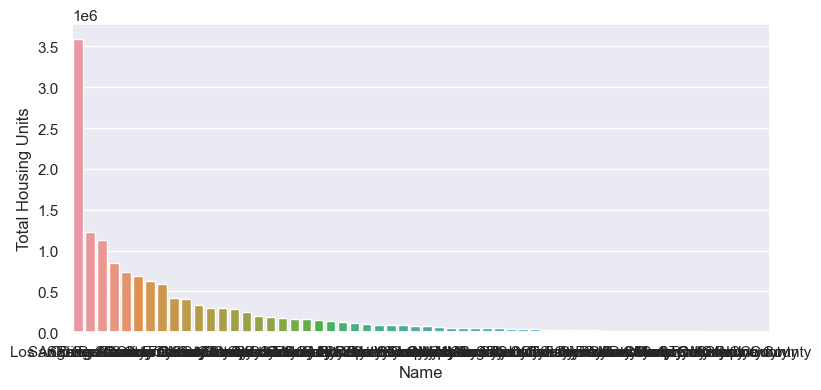

In [23]:
sns.barplot(
    df_single_state,
    x = 'Name',
    y = 'Total Housing Units'

)

#### 4.  Modify the Bar Chart's parameters.

The previous chart didn't look great.  It was a little narrow and all the labels overlapped.  Let's try that again by changing the figure size and rotating the labels on the X-axis.

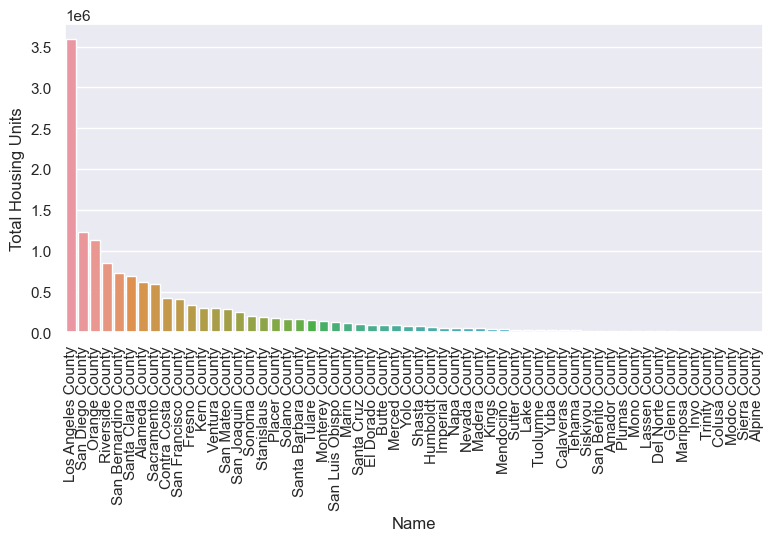

In [24]:
# globally change the figure size
sns.set(rc={"figure.figsize": (9, 4)})

ax = sns.barplot(
    df_single_state,
    x = 'Name',
    y = 'Total Housing Units'

)

# rorate the labels on the X-Axis 90 degrees
ax = ax.set_xticklabels(df_single_state['Name'],rotation=90)

## Plotly

NOTE - At the time of writing, Plotly isn't included in the ArcGIS Pro base Python environment.  To run the cells below, you'll need to create a new environment and install Plotly.  Alternatively, if you have access to an ArcGIS Online Notebook environment, Plotly is already included there.

#### 1.  Import Plotly

Plotly has several components.  The simplest one to start with is the express module.  We can use this to make a quick chart and illustrate the differences between Plotly and some other packages we've looked at.

Import the plotly express module with the following line.

In [10]:
import plotly.express as px

ModuleNotFoundError: No module named 'plotly'

#### 2.  Create a chart

The syntax for creating our basic bar chart in Plotly is fairly simple.  In this case, you're not going to specify a lot of custom options.  The defaults in Plotly are acceptable here.

In [ ]:
fig = px.bar(df_single_state, 
             x='Name', 
             y='Total Housing Units')
fig.show()

You may have already noticed some differences with this chart and the previous charts.  This one is a responsive part of this notebook and feels like part of a web page.  This is because Plotly's Python API incorporates their Javascript API to produce this interactivity.  If you resize this page, the chart will respond accordingly.  Also, as you move your cursor over individual bars you'll see a hover indicator pop up showing information about each bar.

## ArcPy

#### 1.  Prepare the DataFrame for conversion

In [25]:
df_single_state.dtypes

Object ID                                                                                 Int64
County GNIS Code                                                                 string[python]
Geographic Identifier                                                            string[python]
Current class code                                                               string[python]
Current functional status                                                        string[python]
                                                                                      ...      
Households with school-age children (6 to 17 years) of householder                        Int32
Percent of households with school-age children (6 to 17 years) of householder           Float64
Shape Area                                                                              Float64
Shape Length                                                                            Float64
SHAPE                                   

To use ArcPy for charting, we'll first convert our data into a feature class.  Before that, though, you'll need to remove spaces from column names.  The ArcGIS API for Python can do this for you, but in the process you leave a small amount of room for error as you have to guess what the columns get renamed to.  You can rename them explicitly so that there is no guessing.

In [26]:
# keep only the necessary columns
df_for_fc = df_single_state[["Total Housing Units", "Name", 'SHAPE']]

# rename the column with spaces in the name
df_for_fc = df_for_fc.rename(
    columns={
        "Total Housing Units": "total_housing_units"
    }
)

#### 2.  Convert to a feature class.

Now that you've prepared your data, you can export that data to a feature class.  ArcPy's charting module accepts feature classes as inputs.

In [27]:
import arcpy
fc_memory = df_for_fc.spatial.to_featureclass("memory\\single_state")

TIP - The `memory` workspace is a special workpace in the ArcGIS ecosystem.  It works like a temporary file geodatabases.  You can write feature classes, tables, and other datasets to the `memory` workspace.  They're stored there in memory temporarily.  At the end of your script or process, the workspace is deleted.  It's a great spot for intermediate data that you don't need to persist to disk.

#### 3.  Creat a bar chart with ArcPy

The ArcPy charting module is very similar to the other packages we've explored in that you can create chart objects, manipulate them, and show or export them.  In the code block below, you'll create a bar chart, then sort the columns by amount in descending order.

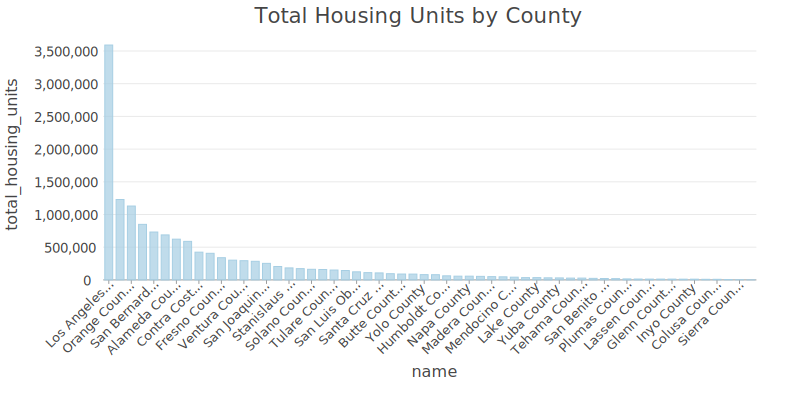

In [28]:
# create a chart object
arcpy_bar = arcpy.charts.Bar(
    x="Name",
    y = ["total_housing_units"],
    title = "Total Housing Units by County",
    dataSource = fc_memory,
    displaySize = (800, 400)
)

# sort the data by values
arcpy_bar.yAxis.sort='DESC'

# display the chart
arcpy_bar

## Interactive Charts

Because we're using an interactive Jupyter Notebook to work with these charts, we can use Jupyter widgets to interact with our charts.  This is a great method for exploring our data and the relationships between different variables or fields.

#### 1.  Set up widgets.

To start this portion of the exercise, you'll need to set up some widgets.  There's a package called `ipywidgets` included in your Python environment with Jupyter installed.  Start by importing that package.  Then you can create some `Dropdown` objects that you can use to interact with charts.

In [29]:
import ipywidgets

drop_down_x = ipywidgets.Dropdown(
    options = df_single_state.columns,
    values = df_single_state.columns,
    description = "X Axis",
    value = 'Percent of housing units that are urban'
)

drop_down_y = ipywidgets.Dropdown(
    options = df_single_state.columns,
    values = df_single_state.columns,
    description = "Y Axis",
    value = 'Vacancy rate'
)


If you return either of those `Dropdown` objects, you'll get a rendered drop down selector in the output of that cell.  We'll wait to do that though until we have something to interact with.

#### 2.  Write a function to show a chart.

To get a good interaction between the drop down selectors and a chart, we'll need to write a function that shows a chart.  In this case, you can just write a simple function that creates a seaborn scatterplot.

In [30]:
def show_a_chart(x_field, y_field):
    sns.scatterplot(df_single_state, x=x_field, y=y_field)

#### 3.  Use widgets to interact with a chart

Now that you've got drop-downs set up and a chart configured, you can use those drop-downs as inputs to the chart function.  You can use the `interact` function included with the `ipywidgets` package.  This function is interesting because it accepts another function as its first parameter.  Then it accepts the paramters for that function as additional arguments.

In [31]:
ipywidgets.interact(show_a_chart,  # the function you wrote
                    x_field = drop_down_x,  # the x_field parameter in your function
                    y_field = drop_down_y # the y_field parameter in your function
                   )

interactive(children=(Dropdown(description='X Axis', index=17, options=('Object ID', 'County GNIS Code', 'Geog…

<function __main__.show_a_chart(x_field, y_field)>